# Text entailment using BERT model

Fine tunning helper resources: 
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://huggingface.co/docs/transformers/training

In [27]:
import os
import torch
import random
import wget
import zipfile
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [28]:
MODEL_VERSION = 1.0
MODEL_PATH = f'./saved_model/{MODEL_VERSION}'
MODEL_HISTORY_PATH = f'{MODEL_PATH}/history.csv'

DATASET_URL = 'https://nlp.stanford.edu/projects/snli/snli_1.0.zip'
DATASET_DIR_PATH = './data'
DATASET_NAME = 'snli_1.0'
DATASET_DOWNLOAD_PATH = f'{DATASET_DIR_PATH}/{DATASET_NAME}.zip'
DATA_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_dev.txt'
DATA_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_test.txt'
DATA_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_train.txt'

BATCH_SIZE = 50

LABELS = {'neutral': 0, 'contradiction': 1, 'entailment': 2}

In [29]:
if not os.path.isdir(DATASET_DIR_PATH):
    os.mkdir(DATASET_DIR_PATH)
    wget.download(DATASET_URL, out=DATASET_DOWNLOAD_PATH)
    
    with zipfile.ZipFile(DATASET_DOWNLOAD_PATH, 'r') as z:
        z.extractall(DATASET_DIR_PATH)
        os.remove(DATASET_DOWNLOAD_PATH)


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
class SNLIDataset(Dataset):
    def __init__(self, csv_file: str):
        self.data = pd.read_csv(csv_file, sep='\t')
        self.data = self.data[['gold_label', 'sentence1', 'sentence2']]
        self.data = self.data[self.data['gold_label'] != '-']
        self.data.dropna(inplace=True)

        self.sentences: pd.Series = '[CLS]' + self.data['sentence1'] + '[SEP]' + self.data['sentence2'] + '[SEP]'

        # find the max length
        # tokens = [tokenizer.tokenize(sen) for sen in self.sentences.values]
        # self.max_len = max([len(t_list) for t_list in tokens])
        self.max_len = 200

        self.labels = [LABELS[v] for v in self.data['gold_label'].values]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, torch.tensor, int]:
        sentence = self.sentences.iloc[index]

        encoded = tokenizer.encode_plus(
            sentence,
            return_tensors='pt',
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=self.max_len,
        )

        return encoded['input_ids'], encoded['attention_mask'], self.labels[index]

In [ ]:
train = SNLIDataset(csv_file=DATA_TRAIN)
dev = SNLIDataset(csv_file=DATA_DEV)
test = SNLIDataset(csv_file=DATA_TEST)

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, sampler=RandomSampler(train))
dev_loader = DataLoader(dev, batch_size=BATCH_SIZE, sampler=SequentialSampler(train))
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3, output_attentions=False, output_hidden_states=False)

In [ ]:
model.to(device)

In [25]:
max_epoch = 3

In [26]:
optimizer = AdamW(model.parameters())

In [13]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
if not os.path.isdir(MODEL_PATH):

    history = []

    for epoch in range(max_epoch):
        print(f'Epoch {epoch + 1}/{max_epoch}')

        # Training
        train_bar = tqdm(total=len(train_loader), position=1, desc="Training")
        
        total_train_loss = 0

        model.train()  

        for batch in train_loader:
            # squeeze fix the tensor dimenssion
            batch_ids = batch[0].squeeze(1).to(device)
            batch_masks = batch[1].squeeze(1).to(device)
            batch_labels = batch[2].to(device)

            model.zero_grad()

            output = model(batch_ids, token_type_ids = None, attention_mask = batch_masks, labels = batch_labels)
            loss = output.loss

            total_train_loss += loss.item()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_bar.update(1)
            train_bar.set_postfix({'loss': total_train_loss / len(train_loader)})

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Evaluation
        eval_bar = tqdm(total=len(dev_loader), position=0, desc="Validation")
        
        total_eval_loss = 0
        total_eval_accuracy = 0

        model.eval()

        for batch in dev_loader:
            batch_ids = batch[0].squeeze(1).to(device)
            batch_masks = batch[1].squeeze(1).to(device)
            batch_labels = batch[2].to(device)

            with torch.no_grad():
                output = model(batch_ids, token_type_ids = None, attention_mask = batch_masks, labels = batch_labels)
        
            total_eval_loss += output.loss.item()
            
            # Accumulate the accuracy
            logits = output.logits.numpy()
            logits_labels = np.argmax(logits, axis=1)
            accuracy = np.sum(logits_labels == batch_labels.numpy()) / len(batch_labels)
            total_eval_accuracy += accuracy

            eval_bar.update(1)
            eval_bar.set_postfix({'loss': total_train_loss / len(train_loader), 'acc': total_eval_accuracy / len(dev_loader)})

        avg_eval_loss = total_eval_loss / len(dev_loader)
        avg_eval_accuracy = total_eval_accuracy / len(dev_loader)

        history.append({
            'epoch': epoch,
            'training_loss': avg_train_loss,
            'validation_loss': avg_eval_loss,
            'validation_accuracy': avg_eval_accuracy
        })

        # Save every epoch
        model.save_pretrained(MODEL_PATH)
        pd.DataFrame(history).set_index('epoch').to_csv(MODEL_HISTORY_PATH)

else:
    print(f'Model version {MODEL_VERSION} already exists')

Epoch 1/3


Training:   0%|          | 0/10988 [00:00<?, ?it/s]

Validation:   0%|          | 0/10988 [00:00<?, ?it/s]

Epoch 2/3


Training:   0%|          | 0/10988 [00:00<?, ?it/s]

Validation:   0%|          | 0/10988 [00:00<?, ?it/s]

Epoch 3/3


Training:   0%|          | 0/10988 [00:00<?, ?it/s]

Validation:   0%|          | 0/10988 [00:00<?, ?it/s]

In [16]:
history = pd.read_csv(MODEL_HISTORY_PATH)
history

,epoch,training_loss,validation_loss,validation_accuracy
0,0,0.000116,0.000116,0.000036
1,1,0.000131,0.000165,0.000029
2,2,0.000144,0.000113,0.000029


In [17]:
l_model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

In [18]:
# Accuracy
l_model.eval()

prediction, true_labeles = [], []
test_bar = tqdm(total=len(test_loader), desc="Testing")

for batch in test_loader:
    batch_ids = batch[0].squeeze(1).to(device)
    batch_masks = batch[1].squeeze(1).to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        output = l_model(batch_ids, token_type_ids = None, attention_mask = batch_masks)

    logits = output.logits
    prediction.append(np.argmax(logits.numpy(), axis=1))
    true_labeles.append(batch_labels.numpy())

    test_bar.update(1)

Testing:   0%|          | 0/197 [00:00<?, ?it/s]

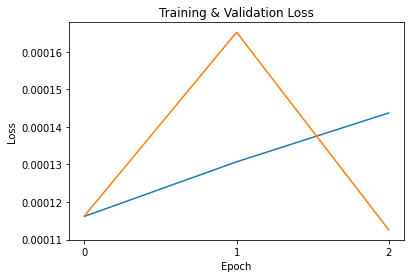

In [23]:
plt.plot(history['training_loss'], label='Training')
plt.plot(history['validation_loss'], label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(max_epoch))
plt.ylabel('Loss')
plt.show()

### Classification Report

In [24]:
all_prediction = np.concatenate(prediction)
all_true_labels = np.concatenate(true_labeles)

print(classification_report(all_prediction, all_true_labels, labels=np.unique(all_true_labels), zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46        50
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.30        50
   macro avg       0.33      0.10      0.15        50
weighted avg       1.00      0.30      0.46        50

